In [19]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4th,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2nd,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4th,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3rd,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5th,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2nd,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4th,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3rd,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3rd,September,130,82


In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculating MAE, RMSE, MSE, and R² for the surgeon's estimated operation time
surgeon_mae = mean_absolute_error(df['surgery duration'], df['surgeon estimated op time'])
surgeon_rmse = np.sqrt(mean_squared_error(df['surgery duration'], df['surgeon estimated op time']))
surgeon_mse = mean_squared_error(df['surgery duration'], df['surgeon estimated op time'])
surgeon_r2 = r2_score(df['surgery duration'], df['surgeon estimated op time'])

surgeon_mae, surgeon_rmse, surgeon_mse, surgeon_r2

(70.8192520732668, 94.3469303146079, 8901.343259789479, 0.2590043404892589)

In [21]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room', 'op code']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

cross_val_scores_rf = {}

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}


# Training models for each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration'] 

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model with cross-validation
    department_model = RandomForestRegressor(random_state=42)
    cv_scores_rf = cross_val_score(department_model, X_dept, y_dept, cv=5)
    cross_val_scores_rf[dept] = cv_scores_rf.mean()

    # Training and saving the final model
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)


# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_rf = mean_absolute_error(y_test_all, final_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_rf = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_rf, rmse_rf, r2_rf

print(f"Ensemble MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")

Ensemble MAE: 16.31609725840466, RMSE: 31.194884246574414, R²: 0.9182941982331316


In [23]:
# Retraining the models with the default parameters of RandomForestRegressor
default_models = {}
default_predictions = {}
default_mae = {}
dept_sample_counts = {}
actual_surgery_durations = {}

for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
    # Storing the number of samples per department
    dept_sample_counts[dept] = len(dept_data)

    if len(dept_data) > 0:
        X_dept = dept_data.drop('surgery duration', axis=1)
        y_dept = dept_data['surgery duration']

        # Actual surgery durations for each department
        actual_surgery_durations[dept] = y_dept

        # Splitting the data for the department
        X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

        # Training the model with default parameters
        default_model = RandomForestRegressor(random_state=42)
        default_model.fit(X_train_dept, y_train_dept)
        default_models[dept] = default_model

        # Predicting on the test set
        dept_predictions = default_model.predict(X_test_dept)
        default_predictions[dept] = dept_predictions

        # Calculating MAE for each department
        dept_mae = mean_absolute_error(y_test_dept, dept_predictions)
        default_mae[dept] = dept_mae

# Preparing the data for visualization
dept_data_for_visualization = pd.DataFrame({
    'Department': default_mae.keys(),
    'MAE': default_mae.values(),
    'Sample Count': [dept_sample_counts[dept] for dept in default_mae.keys()],
    'Average Surgery Duration': [actual_surgery_durations[dept].mean() for dept in default_mae.keys()]
})

dept_data_for_visualization.sort_values(by='Department')

,Department,MAE,Sample Count,Average Surgery Duration
8,Cardiovascular Thoracic Surgery,48.856469,9341,233.352425
0,General Surgery,35.513814,36466,155.665771
7,Neurosurgery,49.642636,7187,239.383053
4,Obstetrics & Gynecology,34.699900,11510,131.534839
3,Ophthalmology,12.906626,17437,57.755921
2,Orthopedics,34.596868,16617,133.923572
1,Otolaryngology,44.702501,11772,139.036018
16,Pediatric Neurosurgery,65.318504,1166,296.249571
14,Pediatric Ophthalmology,10.321978,7857,56.627339
10,Pediatric Orthopedics,49.609155,3905,143.927017


In [25]:
# Extracting predictions and actual values for the 'General Surgery' department
dept_name = 'General Surgery'
general_surgery_predictions = default_predictions[dept_name]
general_surgery_actual = actual_surgery_durations[dept_name]

# Adjusting to use only the test set data for General Surgery department
dept_col_name = 'surgical department_' + dept_name
dept_test_data = df_encoded[df_encoded[dept_col_name] == 1]

# Splitting the data for the department again to get the test set
_, X_test_dept, _, y_test_dept = train_test_split(dept_test_data.drop('surgery duration', axis=1), 
                                                  dept_test_data['surgery duration'], 
                                                  test_size=0.2, 
                                                  random_state=42)

# Extracting the actual surgery durations from the test set
general_surgery_actual_test = y_test_dept

# Creating a DataFrame for detailed analysis with test set data
general_surgery_analysis_test = pd.DataFrame({
    'Actual Duration': general_surgery_actual_test,
    'Predicted Duration': general_surgery_predictions
})

# Calculating the difference between actual and predicted values
general_surgery_analysis_test['Difference'] = general_surgery_analysis_test['Actual Duration'] - general_surgery_analysis_test['Predicted Duration']
general_surgery_analysis_test['Absolute Difference'] = abs(general_surgery_analysis_test['Difference'])

# Sorting the DataFrame by absolute difference
general_surgery_analysis_test_sorted = general_surgery_analysis_test.sort_values(by='Absolute Difference', ascending=False)

general_surgery_analysis_test_sorted.head(10)  # Displaying the top 10 entries with the largest differences



,Actual Duration,Predicted Duration,Difference,Absolute Difference
3621,765,103.06,661.94,661.94
140705,1044,507.04,536.96,536.96
150188,690,194.60,495.40,495.40
70228,810,353.42,456.58,456.58
150483,612,161.51,450.49,450.49
59073,810,375.43,434.57,434.57
16009,613,184.82,428.18,428.18
135450,462,888.32,-426.32,426.32
114050,685,288.49,396.51,396.51
99362,540,150.46,389.54,389.54


In [26]:
# Calculating the absolute difference for the entire dataset
# First, we need to predict for the entire dataset using the trained models for each department
all_predictions = []

# Loop through each department, predict, and store the results
for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]

    if len(dept_data) > 0:
        X_dept = dept_data.drop('surgery duration', axis=1)
        model = default_models[dept]
        dept_predictions = model.predict(X_dept)
        all_predictions.extend(dept_predictions)

# Add the predictions to the original dataframe
df_encoded['Predicted Duration'] = all_predictions

# Calculate the absolute difference for the entire dataset
df_encoded['Absolute Difference'] = abs(df_encoded['surgery duration'] - df_encoded['Predicted Duration'])

# Sorting by highest errors
sorted_by_error = df_encoded.sort_values(by='Absolute Difference', ascending=False)

# Extracting top error data points for analysis (e.g., top 1%)
top_error_percentile = 99
top_error_threshold = np.percentile(sorted_by_error['Absolute Difference'], top_error_percentile)
top_error_data = sorted_by_error[sorted_by_error['Absolute Difference'] >= top_error_threshold]

# Analyzing common characteristics in top error data points
top_error_analysis = top_error_data.describe(include='all')

top_error_analysis



,age,BMI,condition source value,surgery duration,surgical department_Cardiovascular Thoracic Surgery,surgical department_General Surgery,surgical department_Neurosurgery,surgical department_Obstetrics & Gynecology,surgical department_Ophthalmology,surgical department_Orthopedics,...,op code_P00008435,op code_P00008439,op code_P00008446,op code_P00008447,op code_P00008448,op code_P00008449,op code_P00008450,op code_P00008456,Predicted Duration,Absolute Difference
count,1613.000000,1613.000000,1613.000000,1613.000000,1613,1613,1613,1613,1613,1613,...,1613,1613,1613,1613,1613,1613,1613,1613,1613.000000,1613.000000
unique,NaN,NaN,NaN,NaN,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,NaN,NaN
top,NaN,NaN,NaN,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,1388,1400,1486,1560,1555,1509,...,1613,1613,1613,1613,1613,1613,1613,1613,NaN,NaN
mean,45.954743,23.007928,2219.259144,464.282703,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.499591,597.402356
std,25.592164,12.601225,1667.638275,319.965335,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277.829572,111.724572
min,1.000000,5.510262,52.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.280000,490.050000
25%,19.000000,18.938776,501.000000,75.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.310000,518.510000
50%,54.000000,22.524359,2120.000000,590.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.730000,561.170000
75%,66.000000,25.429116,3761.000000,693.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,585.770000,641.780000


In [27]:
# Calculating the absolute error and error percentage for the top error data
top_error_data['Absolute Error'] = abs(top_error_data['surgery duration'] - top_error_data['Predicted Duration'])
top_error_data['Error Percentage'] = (top_error_data['Absolute Error'] / top_error_data['surgery duration']) * 100

# Summary of the absolute error and error percentage
error_summary = top_error_data[['Absolute Error', 'Error Percentage']].describe()
error_summary

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52184\4051699312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_error_data['Absolute Error'] = abs(top_error_data['surgery duration'] - top_error_data['Predicted Duration'])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52184\4051699312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_error_data['Error Percentage'] = (top_error_data['Absolute Error'] / top_error_data['surgery duration']) * 100


,Absolute Error,Error Percentage
count,1613.000000,1613.000000
mean,597.402356,455.671887
std,111.724572,629.993821
min,490.050000,58.643836
25%,518.510000,87.994845
50%,561.170000,93.250000
75%,641.780000,750.467532
max,1579.720000,8446.800000


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52184\3581795155.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modified_column_names, y=distribution.values, palette="viridis")


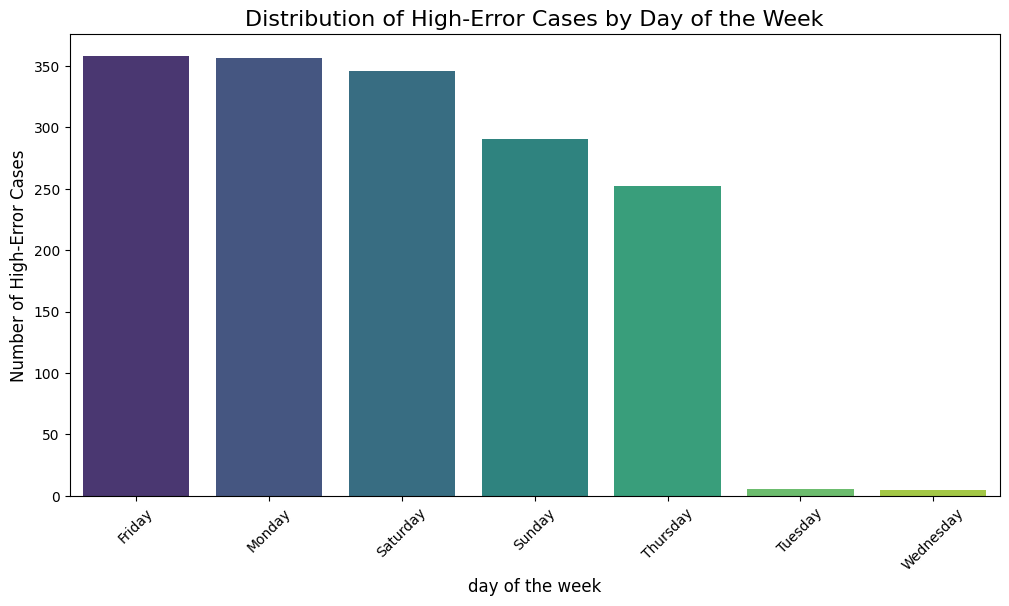

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52184\3581795155.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modified_column_names, y=distribution.values, palette="viridis")


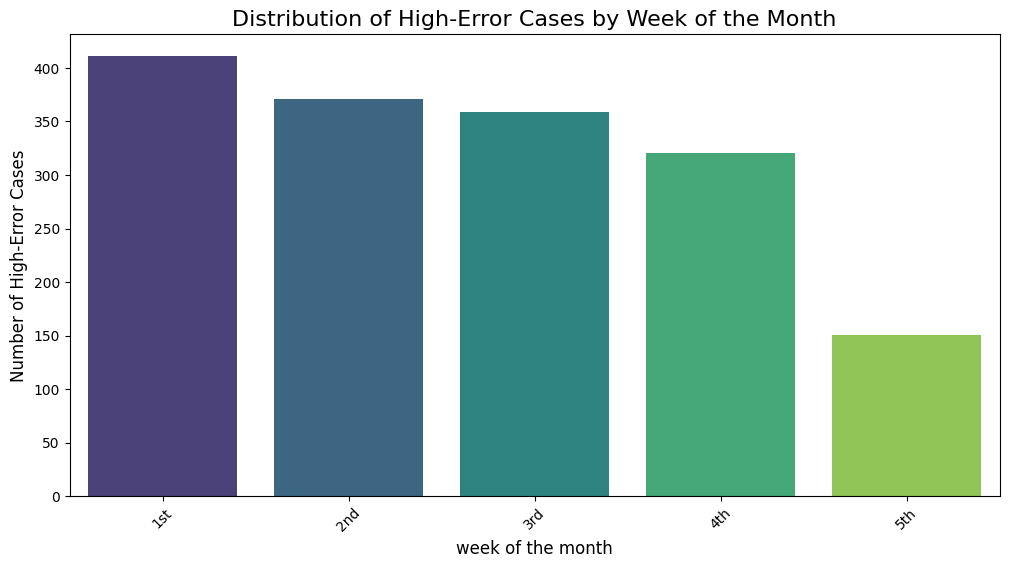

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52184\3581795155.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modified_column_names, y=distribution.values, palette="viridis")


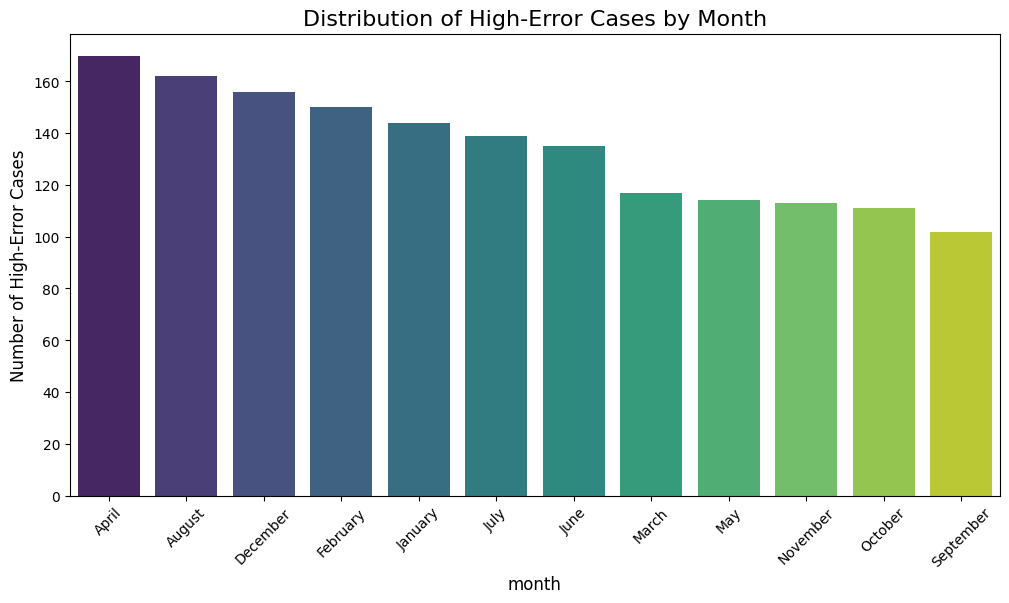

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52184\3581795155.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=modified_column_names, y=distribution.values, palette="viridis")


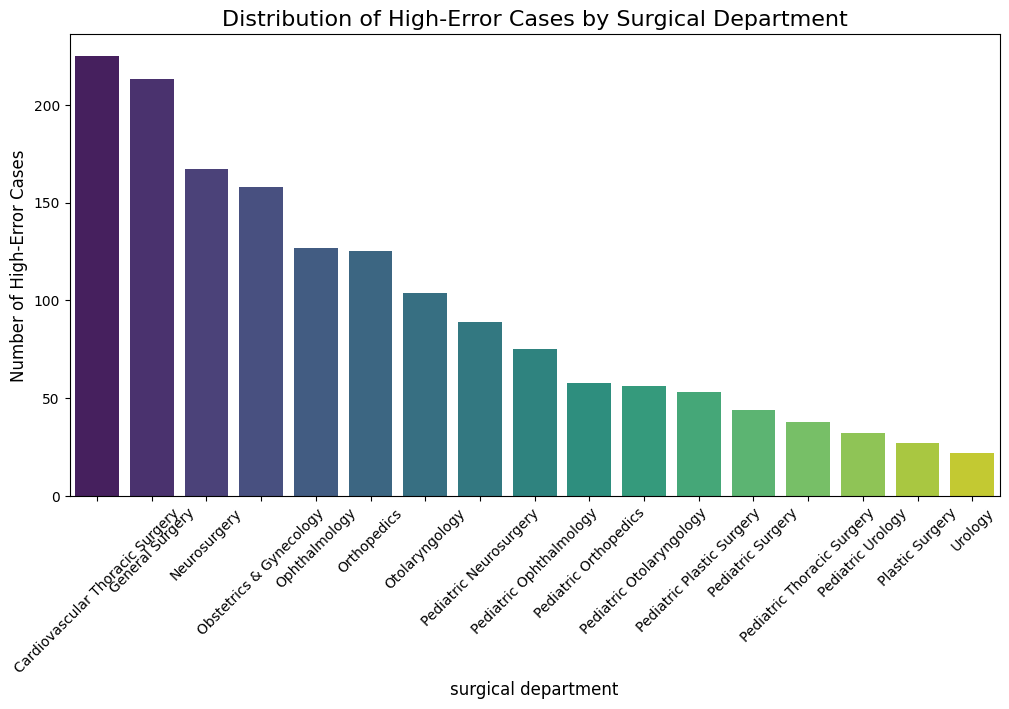

(day of the week_Thursday     358
 day of the week_Monday       356
 day of the week_Friday       346
 day of the week_Tuesday      290
 day of the week_Wednesday    252
 day of the week_Sunday         6
 day of the week_Saturday       5
 dtype: int64,
 week of the month_3rd    411
 week of the month_2nd    371
 week of the month_4th    359
 week of the month_1st    321
 week of the month_5th    151
 dtype: int64,
 month_May          170
 month_April        162
 month_July         156
 month_August       150
 month_March        144
 month_January      139
 month_June         135
 month_February     117
 month_November     114
 month_December     113
 month_October      111
 month_September    102
 dtype: int64,
 surgical department_Cardiovascular Thoracic Surgery    225
 surgical department_General Surgery                    213
 surgical department_Otolaryngology                     167
 surgical department_Plastic Surgery                    158
 surgical department_Neurosurgery      

In [28]:
import seaborn as sns

# Function to create a beautiful bar plot for a given column, with modified column names
def plot_beautiful_distribution_modified(df, column_prefix, title, exact_match=False):
    if exact_match:
        relevant_columns = [col for col in df.columns if col.startswith(column_prefix)]
    else:
        relevant_columns = [col for col in df.columns if column_prefix in col]

    # Modifying column names for the plot
    modified_column_names = [col.replace(column_prefix, '') for col in relevant_columns]

    # Summing boolean flags to calculate distribution and sorting
    distribution = df[relevant_columns].sum().sort_values(ascending=False)

    # Creating a bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=modified_column_names, y=distribution.values, palette="viridis")
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plt.ylabel('Number of High-Error Cases', fontsize=12)
    plt.xlabel(column_prefix.rstrip('_'), fontsize=12)
    plt.show()
    return distribution

# Plotting distributions with modified column names
day_of_week_distribution_beautiful = plot_beautiful_distribution_modified(top_error_data, 'day of the week_', 'Distribution of High-Error Cases by Day of the Week')
week_of_month_distribution_beautiful = plot_beautiful_distribution_modified(top_error_data, 'week of the month_', 'Distribution of High-Error Cases by Week of the Month')
month_distribution_beautiful = plot_beautiful_distribution_modified(top_error_data, 'month_', 'Distribution of High-Error Cases by Month', exact_match=True)
surgical_department_distribution_beautiful = plot_beautiful_distribution_modified(top_error_data, 'surgical department_', 'Distribution of High-Error Cases by Surgical Department')

(day_of_week_distribution_beautiful, week_of_month_distribution_beautiful, month_distribution_beautiful, surgical_department_distribution_beautiful)





In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate and plot the distribution of a given column
def plot_distribution(df, column_name, title):
    distribution = df[column_name].value_counts(normalize=True).head(10)  # Taking top 10 for clarity
    plt.figure(figsize=(10, 6))
    sns.barplot(x=distribution.index, y=distribution.values)
    plt.title(title)
    plt.ylabel('Frequency (%)')
    plt.xlabel(column_name)
    plt.show()
    return distribution

# Plotting distributions for the requested columns
surgeon_id_distribution = plot_distribution(top_error_data, 'surgeon id', 'Top 10 Surgeon IDs with Highest Error Rates')
op_code_distribution = plot_distribution(top_error_data, 'op code', 'Top 10 Surgery Types (op_code) with Highest Error Rates')
condition_source_value_distribution = plot_distribution(top_error_data, 'condition_source_value', 'Top 10 Condition Source Values with Highest Error Rates')

# For surgical departments, day of the week, and month, extracting the relevant columns
surgical_department_columns = [col for col in top_error_data.columns if 'surgical department_' in col]
day_of_week_columns = [col for col in top_error_data.columns if 'day of the week_' in col]
month_columns = [col for col in top_error_data.columns if 'month_' in col]

# Summing boolean flags to calculate distribution
surgical_department_distribution = top_error_data[surgical_department_columns].sum().sort_values(ascending=False).head(10)
day_of_week_distribution = top_error_data[day_of_week_columns].sum().sort_values(ascending=False).head(10)
month_distribution = top_error_data[month_columns].sum().sort_values(ascending=False).head(10)

# Plotting distributions for surgical departments, day of the week, and month
plt.figure(figsize=(10, 6))
surgical_department_distribution.plot(kind='bar')
plt.title('Top 10 Surgical Departments with Highest Error Rates')
plt.ylabel('Number of High-Error Cases')
plt.xlabel('Surgical Department')
plt.show()

plt.figure(figsize=(10, 6))
day_of_week_distribution.plot(kind='bar')
plt.title('Days of the Week with Highest Error Rates')
plt.ylabel('Number of High-Error Cases')
plt.xlabel('Day of the Week')
plt.show()

plt.figure(figsize=(10, 6))
month_distribution.plot(kind='bar')
plt.title('Months with Highest Error Rates')
plt.ylabel('Number of High-Error Cases')
plt.xlabel('Month')
plt.show()

# Returning the distributions for detailed view
(surgeon_id_distribution, op_code_distribution, condition_source_value_distribution, surgical_department_distribution, day_of_week_distribution, month_distribution)



KeyError: 'surgeon id'

In [33]:
# Re-merging the original dataset with the top error data points for broader analysis
top_error_data_broad_corrected = df.merge(top_error_data, left_index=True, right_index=True, how='inner')

# Analyzing departments with most high-error cases
dept_error_distribution_corrected = top_error_data_broad_corrected['surgical department'].value_counts()

# Analyzing surgery types with most high-error cases

# Analyzing patient demographics (age and gender) in high-error cases
gender_distribution_corrected = top_error_data_broad_corrected['gender source value'].value_counts()

# Analyzing time-related factors (day of the week, month, etc.)
day_of_week_distribution_corrected = top_error_data_broad_corrected['day of the week'].value_counts()
month_distribution_corrected = top_error_data_broad_corrected['month'].value_counts()

# Collecting analysis results
analysis_results_corrected = {
    "Department Error Distribution": dept_error_distribution_corrected,
    "Gender Distribution of High-Error Cases": gender_distribution_corrected,
    "Day of the Week Distribution in High-Error Cases": day_of_week_distribution_corrected,
    "Month Distribution in High-Error Cases": month_distribution_corrected
}

analysis_results_corrected



{'Department Error Distribution': surgical department
 Cardiovascular Thoracic Surgery    225
 General Surgery                    213
 Otolaryngology                     167
 Plastic Surgery                    158
 Neurosurgery                       127
 Pediatric Ophthalmology            125
 Orthopedics                        104
 Pediatric Thoracic Surgery          89
 Pediatric Otolaryngology            75
 Ophthalmology                       58
 Pediatric Surgery                   56
 Obstetrics & Gynecology             53
 Pediatric Neurosurgery              44
 Urology                             38
 Pediatric Urology                   32
 Pediatric Orthopedics               27
 Pediatric Plastic Surgery           22
 Name: count, dtype: int64,
 'Gender Distribution of High-Error Cases': gender source value
 M    934
 F    679
 Name: count, dtype: int64,
 'Day of the Week Distribution in High-Error Cases': day of the week
 Thursday     358
 Monday       356
 Friday       346
 Tu

In [34]:
top_error_data_broad_corrected

,age_x,gender source value,BMI_x,admission department,division,ward,asa class,surgeon id,surgical department,op code,...,op code_P00008446,op code_P00008447,op code_P00008448,op code_P00008449,op code_P00008450,op code_P00008456,Predicted Duration,Absolute Difference,Absolute Error,Error Percentage
120,96,M,25.640568,General Surgery,Admission,EICU,2,29078,General Surgery,P00002818,...,False,False,False,False,False,False,66.09,671.91,671.91,91.044715
355,67,M,26.564813,Cardiovascular Thoracic Surgery,Admission,RICU,3,6039,Cardiovascular Thoracic Surgery,P00000902,...,False,False,False,False,False,False,146.19,528.81,528.81,78.342222
411,69,M,29.912202,Cardiovascular Thoracic Surgery,Admission,RICU,3,31030,Cardiovascular Thoracic Surgery,P00006450,...,False,False,False,False,False,False,67.25,495.75,495.75,88.055062
1298,43,M,24.048050,Pediatric Thoracic Surgery,Admission,PICU,3,8487,Pediatric Thoracic Surgery,P00000902,...,False,False,False,False,False,False,211.48,613.52,613.52,74.366061
1317,74,M,26.841438,Otolaryngology,Admission,102,2,5956,Otolaryngology,P00007872,...,False,False,False,False,False,False,103.90,657.10,657.10,86.346912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161062,1,F,17.107895,Pediatric Ophthalmology,Admission,5B,1,6268,Pediatric Ophthalmology,P00006629,...,False,False,False,False,False,False,720.29,662.29,662.29,1141.879310
161088,5,F,16.660872,Pediatric Surgery,Day,PDSC,1,100874,Pediatric Surgery,P00004189,...,False,False,False,False,False,False,854.68,844.68,844.68,8446.800000
161103,1,M,11.609977,Pediatric Surgery,Admission,PICU,2,101264,Pediatric Surgery,P00007057,...,False,False,False,False,False,False,779.72,540.72,540.72,226.242678
161118,13,F,24.605254,Pediatric Otolaryngology,Day,PDSC,2,6154,Pediatric Otolaryngology,P00002398,...,False,False,False,False,False,False,556.84,513.84,513.84,1194.976744


In [37]:
# Extracting the top 1% highest-error data points for broader analysis
top_error_data_broad = df.merge(top_error_data, left_index=True, right_index=True)

# Correcting the syntax error and re-running the analysis

# Analyzing departments with most high-error cases
dept_error_distribution = top_error_data_broad['surgical department'].value_counts()

# Analyzing surgery types with most high-error cases
surgery_type_error_distribution = top_error_data_broad['op code'].value_counts()

# Analyzing patient demographics (age and gender) in high-error cases
age_distribution = top_error_data_broad['age'].describe()
gender_distribution = top_error_data_broad['gender source value'].value_counts()

# Analyzing time-related factors (day of the week, month, etc.)
day_of_week_distribution = top_error_data_broad['day of the week'].value_counts()
month_distribution = top_error_data_broad['month'].value_counts()

# Collecting analysis results
analysis_results = {
    "Department Error Distribution": dept_error_distribution,
    "Surgery Type Error Distribution": surgery_type_error_distribution,
    "Age Distribution of High-Error Cases": age_distribution,
    "Gender Distribution of High-Error Cases": gender_distribution,
    "Day of the Week Distribution in High-Error Cases": day_of_week_distribution,
    "Month Distribution in High-Error Cases": month_distribution
}

analysis_results


KeyError: 'age'

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_52184\3931736076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')


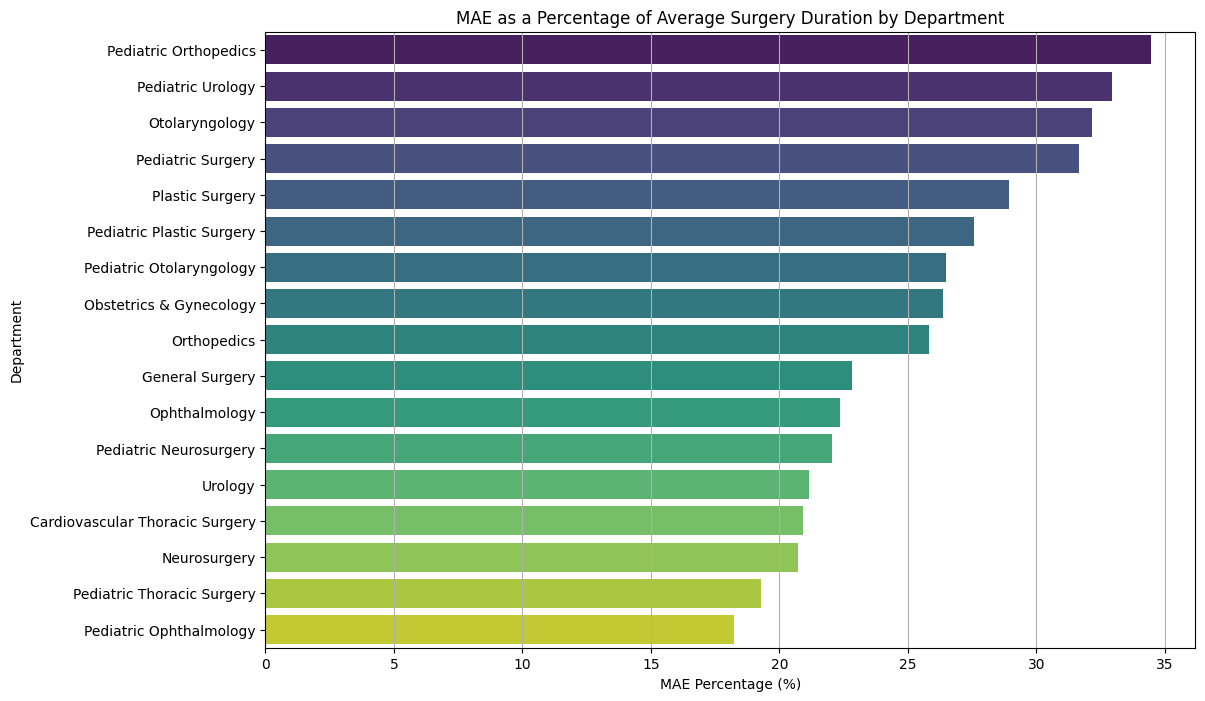

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating the MAE as a percentage of the average surgery duration
dept_data_for_visualization['MAE Percentage'] = (dept_data_for_visualization['MAE'] / dept_data_for_visualization['Average Surgery Duration']) * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')
    
plt.title('MAE as a Percentage of Average Surgery Duration by Department')
plt.xlabel('MAE Percentage (%)')
plt.ylabel('Department')
plt.grid(axis='x')
plt.show()



In [38]:
# Separating the departments into pediatric and adult categories
pediatric_data = dept_data_for_visualization[dept_data_for_visualization['Department'].str.startswith('Pediatric')]
adult_data = dept_data_for_visualization[~dept_data_for_visualization['Department'].str.startswith('Pediatric')]

In [39]:
# Sorting the adult and pediatric data based on Average Surgery Duration
adult_data_sorted = adult_data.sort_values(by='Average Surgery Duration', ascending=False)
pediatric_data_sorted = pediatric_data.sort_values(by='Average Surgery Duration', ascending=False)

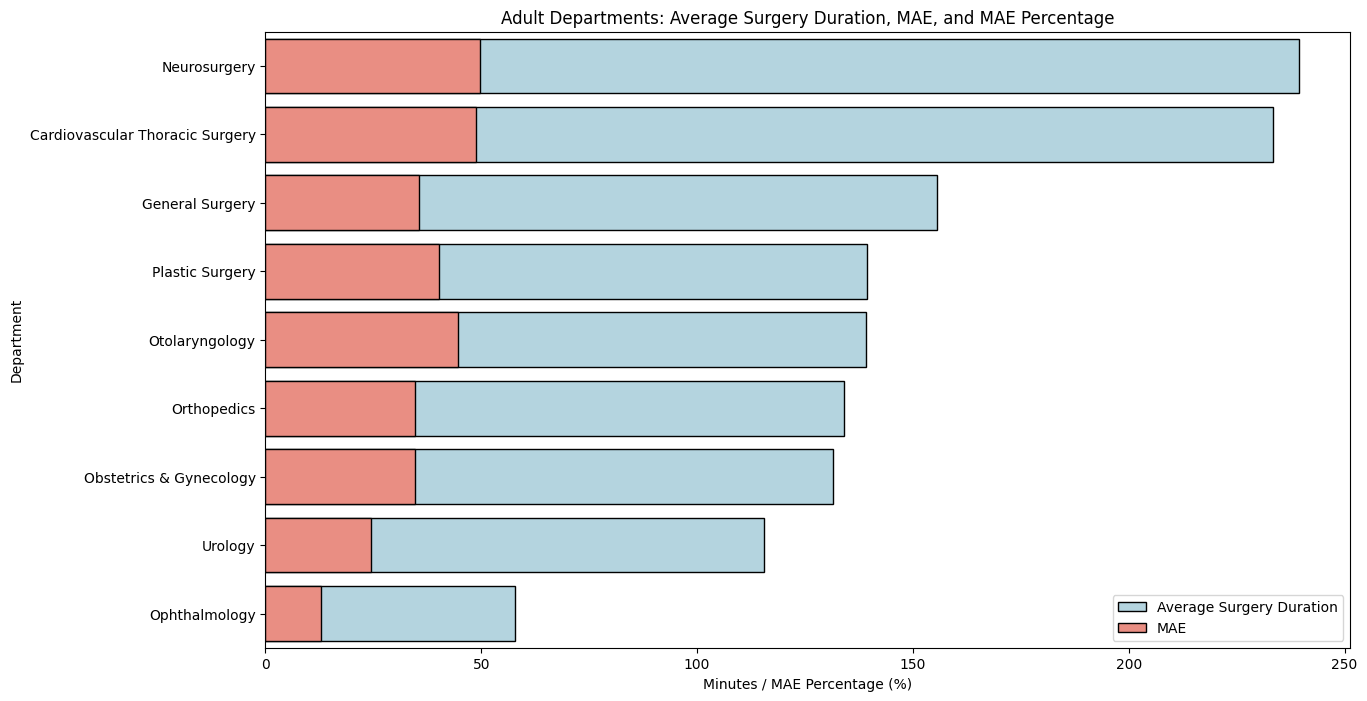

In [40]:
# Combined plot for both Adult and Pediatric Departments, sorted by Average Surgery Duration
plt.figure(figsize=(14, 8))

# Plot for Adult Departments
sns.barplot(x='Average Surgery Duration', y='Department', data=adult_data_sorted, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=adult_data_sorted, color='salmon', edgecolor='black', label='MAE')
plt.title('Adult Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()

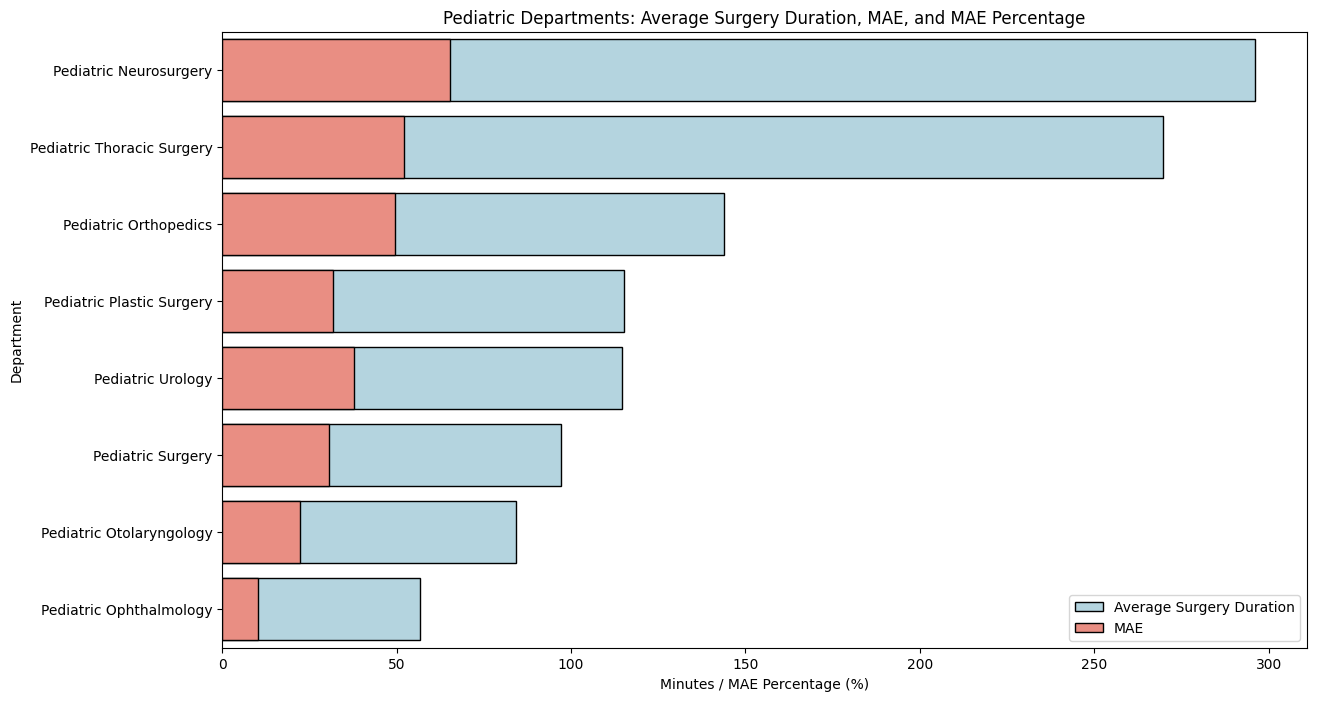

In [41]:
# Plot for Pediatric Departments
plt.figure(figsize=(14, 8))
sns.barplot(x='Average Surgery Duration', y='Department', data=pediatric_data_sorted, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=pediatric_data_sorted, color='salmon', edgecolor='black', label='MAE')
plt.title('Pediatric Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()

In [42]:
# Displaying adult_data as a table
adult_data_table = adult_data[['Department', 'Average Surgery Duration', 'MAE', 'MAE Percentage']].sort_values(by='Average Surgery Duration', ascending=False)
adult_data_table

,Department,Average Surgery Duration,MAE,MAE Percentage
7,Neurosurgery,239.383053,49.642636,20.737740
8,Cardiovascular Thoracic Surgery,233.352425,48.856469,20.936774
0,General Surgery,155.665771,35.513814,22.814145
6,Plastic Surgery,139.252837,40.278948,28.925047
1,Otolaryngology,139.036018,44.702501,32.151742
2,Orthopedics,133.923572,34.596868,25.833293
4,Obstetrics & Gynecology,131.534839,34.699900,26.380767
5,Urology,115.427910,24.433103,21.167414
3,Ophthalmology,57.755921,12.906626,22.346844


In [43]:
# Displaying adult_data as a table
pediatric_data_table = pediatric_data[['Department', 'Average Surgery Duration', 'MAE', 'MAE Percentage']].sort_values(by='Average Surgery Duration', ascending=False)
pediatric_data_table

,Department,Average Surgery Duration,MAE,MAE Percentage
16,Pediatric Neurosurgery,296.249571,65.318504,22.048472
11,Pediatric Thoracic Surgery,269.852878,52.083537,19.300716
10,Pediatric Orthopedics,143.927017,49.609155,34.468272
15,Pediatric Plastic Surgery,115.201977,31.766918,27.574976
12,Pediatric Urology,114.517983,37.740420,32.955890
13,Pediatric Surgery,97.210395,30.774422,31.657543
9,Pediatric Otolaryngology,84.302394,22.325837,26.483040
14,Pediatric Ophthalmology,56.627339,10.321978,18.227907


In [44]:
# Training a model on the entire dataset
full_model = RandomForestRegressor(random_state=42)
full_model.fit(X_train_all, y_train_all)

# Predicting on the test set
full_model_predictions = full_model.predict(X_test_all)

# Evaluating the full model's performance
full_model_mae = mean_absolute_error(y_test_all, full_model_predictions)
full_model_rmse = np.sqrt(mean_squared_error(y_test_all, full_model_predictions))
full_model_r2 = r2_score(y_test_all, full_model_predictions)

full_model_mae, full_model_rmse, full_model_r2


(32.95421042157714, 56.3171938489969, 0.73370184792376)

In [45]:
import matplotlib.pyplot as plt

# Preparing data for comparison plot and table
comparison_data = {
    "Model Type": ["Department-Specific Model", "General Model", "Surgeon's Estimate"],
    "MAE": [mae, full_model_mae, surgeon_mae],
    "RMSE": [rmse, full_model_rmse, surgeon_rmse]
}

# Creating a DataFrame for easy plotting
comparison_df = pd.DataFrame(comparison_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for MAE
comparison_df.plot(kind='bar', x='Model Type', y='MAE', ax=ax1, color='skyblue', position=1, width=0.4, legend=False)
ax1.set_ylabel('Mean Absolute Error (MAE)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(comparison_df['Model Type'], rotation=0)  # Set x-axis labels horizontally

# Creating a second y-axis for RMSE
ax2 = ax1.twinx()
comparison_df.plot(kind='bar', x='Model Type', y='RMSE', ax=ax2, color='salmon', position=0, width=0.4, legend=False)
ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')
ax2.set_xticklabels(comparison_df['Model Type'], rotation=0)  # Set x-axis labels horizontally

# Title and labels
plt.title('Comparison of Model Performance: Department-Specific, General Model, Surgeon\'s Estimate')
ax1.set_xlabel('Model Type')

plt.show()
# Creating a table for comparison
comparison_table = comparison_df.set_index('Model Type')
comparison_table


NameError: name 'mae' is not defined